# Bright time survey simulations

In [5]:
# Python imports
from importlib import reload
import os
import numpy as np
import astropy.io.fits as fits
import astropy.coordinates as c
from astropy.table import Table
import astropy.units as u
import mpl_toolkits.basemap
import matplotlib.pyplot as pl

In [6]:
# Desi-specific imports
import desitarget.mock.io as mock_io
from desitarget import mws_mask
import desiutil.plots as desiplots
import bright_analysis.sweeps.io as sweeps
reload(sweeps);

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Simulation config

In [8]:
SIM_ROOT    = '/gpfs/data/dph3apc/desi/mysurveys/12apr2017_full'
CONFIG_YAML = os.path.join(SIM_ROOT,'input/mock_bright.yaml')

In [9]:
# Root paths to sweeps
sweep_roots = sweeps.sweep_mock_roots(CONFIG_YAML,'output/sweep')

In [10]:
import yaml
with open(os.path.join(SIM_ROOT,'input/mock_bright.yaml'),'r') as f:
    config = yaml.load(f)

## 2. Load data from sweeps

Sweeps are the subset of the mock that pass through the target selection routines and hence appear in `targets.fits`. These are further split into `observed` (those that get a fiber during the survey) and `unobserved` (those that don't).

Here we look at `MWS_MAIN` only.

In [11]:
# To read the whole mock (not necessary)
# mock = mock_io.read_galaxia(config['sources']['MWS_MAIN']['root_mock_dir'],'MWS_MAIN');

In [12]:
# targets.fits (output of target selection, input to fibre assignment)
targets  = fits.getdata(os.path.join(SIM_ROOT,'input/bright/targets.fits'))

In [13]:
Table(targets[0:3])

TARGETID,RA,DEC,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,BRICKNAME,DECAM_FLUX [6],SHAPEDEV_R,SHAPEEXP_R,DEPTH_R,GALDEPTH_R
int64,float64,float64,int64,int64,int64,float64,float64,str8,float32,float32,float32,float32,float32
4451537108091777804,55.837726593,-1.89100062847,1152921504606846976,1,0,0.929130298268,4.0,0557m020,0.0 .. 0.0,0.0,0.0,23.6555,23.5037
1364231152663687272,32.2679862976,-1.91859793663,1152921504606846976,1,0,0.956074678554,4.0,0322m020,0.0 .. 0.0,0.0,0.0,24.446,24.1766
2797048408888561319,58.6047515869,-5.62304973602,1152921504606846976,1,0,0.694891495305,4.0,0584m055,0.0 .. 0.0,0.0,0.0,24.6049,24.4386


In [14]:
# Read the sweeps. This uses a function in bright_analysis.
data_obs = sweeps.prepare_sweep_data(os.path.join(SIM_ROOT,sweep_roots['MWS_MAIN']),epoch=2,filetype='observed')

Loading data for epoch 2 under /gpfs/data/dph3apc/desi/mysurveys/12apr2017_full/output/sweep/gpfs/data/DESI/mocks/mws/galaxia/alpha/0.0.3/bricks
Read 6276473 rows from 215 files in 119.695039s


In [18]:
Table(data_obs[0:3])

X,Y,Z,l,b,RA,DEC,pm_l,pm_b,pm_RA,pm_DEC,pm_l_kms,pm_b_kms,pm_RA_kms,pm_DEC_kms,v_helio,d_helio,DM,ABV,SDSSu_true_nodust,SDSSu_true,SDSSu_obs,SDSSg_true_nodust,SDSSg_true,SDSSg_obs,SDSSr_true_nodust,SDSSr_true,SDSSr_obs,SDSSi_true_nodust,SDSSi_true,SDSSi_obs,SDSSz_true_nodust,SDSSz_true,SDSSz_obs,FeH,age,teff,logg,mtip,mact,smass,popid,brickname,brickid,vRcyl,vPHIcyl,vZcyl,vX,vY,vZ,vU,vV,vW,objid,TARGETROW,TARGETID,IN_FOOTPRINT
float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes8,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int32,int64,int8
8.01468,-0.0413183,-0.108568,109.555,-68.0077,7.86482761917,-5.65632887484,-39.5282590843,60.748746005,56.7863132563,-27.8919850037,-21.9380521347,33.7153516965,-21.9380521347,33.7153516965,16.1917,0.117088,5.34256,0.0234312,19.7829,19.9037,19.9037,17.0862,17.175,17.175,15.7268,15.7913,15.7913,14.8743,14.9231,14.9231,14.3716,14.4062,14.4062,0.0192581,8.06439,3.561,4.99783,4.88076,0.30861,0.30861,0,0050m100,175,-45.5713,-234.809,13.2249,46.7812,234.571,13.2249,46.7812,234.571,13.2249,15,25060197,1416010561595807387,84
8.01151,-0.0471332,-0.143189,103.721,-71.2817,6.71628819811,-9.3323296491,-21.6984375079,-3.21752366453,-1.3937421702,-12.5190494381,-15.5495361882,-2.30574209041,-15.5495361882,-2.30574209041,9.11673,0.151186,5.89755,0.0325557,19.2528,19.4207,19.4207,16.7306,16.8541,16.8541,15.4131,15.5027,15.5027,14.7032,14.7711,14.7711,14.2787,14.3268,14.3268,-0.0723448,8.04959,3.58074,4.93048,4.98133,0.398971,0.398971,0,0050m100,175,-13.0706,-230.589,6.9197,14.4269,230.508,6.9197,14.4269,230.508,6.9197,16,25060198,3415727821982734509,84
8.00861,-0.0453298,-0.124809,100.75,-69.7116,5.25963845415,-8.15986062204,-42.9769602696,13.8821170261,-21.8926702796,-31.263475806,-27.1066725669,8.75580772588,-27.1066725669,8.75580772588,22.1444,0.133064,5.62031,0.0258933,21.8274,21.9609,21.9609,18.8817,18.9799,18.9799,17.4363,17.5076,17.5076,16.3844,16.4384,16.4384,15.7713,15.8096,15.8096,0.0356945,8.04588,3.53221,5.09941,4.97799,0.184364,0.184364,0,0050m100,175,-22.4618,-219.063,12.3832,23.7014,218.932,12.3832,23.7014,218.932,12.3832,28,25060200,2779016711637582786,84


In [19]:
data_unobs = sweeps.prepare_sweep_data(os.path.join(SIM_ROOT,sweep_roots['MWS_MAIN']),epoch=2,filetype='unobserved')

Loading data for epoch 2 under /gpfs/data/dph3apc/desi/mysurveys/12apr2017_full/output/sweep/gpfs/data/DESI/mocks/mws/galaxia/alpha/0.0.3/bricks
Read 41185773 rows from 215 files in 121.934272s


## 3. Summary of MWS_MAIN

In [21]:
nselected = len(data_obs)+len(data_unobs)
print('{:d} selected, {:d} observed'.format(nselected,len(data_obs)))
print('{:f}% of selected targets observed'.format(100.0*float(len(data_obs))/float(nselected)))

47462246 selected, 6276473 observed
13.224138% of selected targets observed


In [22]:
def summary_observed(targets,targetrows_obs,targetrows_unobs,target_class,mask):
    """
    """
    target_bit_name = target_class.split('_')[0] + '_TARGET'
    
    targetbit_o  = targets[target_bit_name][targetrows_obs]
    targetbit_u  = targets[target_bit_name][targetrows_unobs]
    
    in_class_o   = targetbit_o & mask.mask(target_class) != 0
    in_class_u   = targetbit_u & mask.mask(target_class) != 0

    n_o =  float(in_class_o.sum())
    n_u =  float(in_class_u.sum())
    n_t = n_o + n_u
    
    print('Of {ntot:d} stars that were selected as {target_class}, {nobs:d} were observed ({frac:5f})'.format(
            target_class=target_class,nobs=int(n_o),ntot=int(n_u),frac=n_o/n_t))
    
    return in_class_o, in_class_u


In [23]:
main_obs, main_unobs = summary_observed(targets,data_obs['TARGETROW'],data_unobs['TARGETROW'],
                                        'MWS_MAIN',mws_mask)

Of 28082419 stars that were selected as MWS_MAIN, 5991944 were observed (0.175849)


In [24]:
faint_obs, faint_unobs = summary_observed(targets,data_obs['TARGETROW'],data_unobs['TARGETROW'],
                                          'MWS_MAIN_VERY_FAINT',mws_mask)

Of 13103354 stars that were selected as MWS_MAIN_VERY_FAINT, 284529 were observed (0.021253)


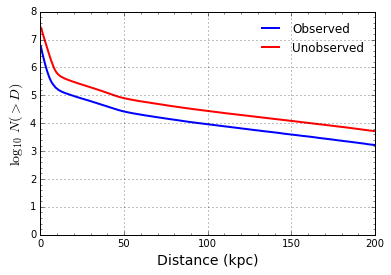

In [25]:
# Observed
d = data_obs['d_helio'][main_obs]
a = np.argsort(d)
y = np.arange(1,1+len(d))
plot(d[a[::-1]],np.log10(y),lw=2,c='b',label='Observed')

# Unobserved
d = data_unobs['d_helio'][main_unobs]
a = np.argsort(d)
y = np.arange(1,1+len(d))
plot(d[a[::-1]],np.log10(y),lw=2,c='r',label='Unobserved')

pl.xlabel('Distance (kpc)',fontsize=14)
pl.ylabel('$\log_{10}\ N(>D)$',fontsize=14)
pl.legend(loc='upper right',frameon=False)
pl.minorticks_on()
pl.grid()
pl.xlim(0,200);

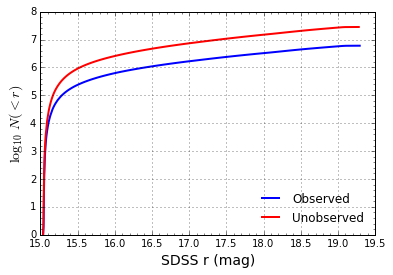

In [26]:
# Observed
d = data_obs['SDSSr_obs'][main_obs]
a = np.argsort(d)
y = np.arange(1,1+len(d))
plot(d[a],np.log10(y),lw=2,c='b',label='Observed')

# Unobserved
d = data_unobs['SDSSr_obs'][main_unobs]
a = np.argsort(d)
y = np.arange(1,1+len(d))
plot(d[a],np.log10(y),lw=2,c='r',label='Unobserved')

pl.xlabel('SDSS r (mag)',fontsize=14)
pl.ylabel('$\log_{10}\ N(<r)$',fontsize=14)
pl.legend(loc='lower right',frameon=False)
pl.minorticks_on()
pl.grid();

We now convert to DECam mags before selection, which means we end up including stars with SDSS magnitudes fainter than our nominal faint limit.

In [128]:
# How many stars fainter than faint limit?
is_v_faint = data_obs['SDSSr_obs'][main_obs] > 19.0
np.sum(is_v_faint)

289028

In [129]:
np.max(data_obs['SDSSr_obs'][main_obs][is_v_faint])

19.292795

In [130]:
s = np.where(data_obs['SDSSr_obs'][main_obs] > 19.0)[0]
Table(data_obs[main_obs][s[0:3]])

X,Y,Z,l,b,RA,DEC,pm_l,pm_b,pm_RA,pm_DEC,pm_l_kms,pm_b_kms,pm_RA_kms,pm_DEC_kms,v_helio,d_helio,DM,ABV,SDSSu_true_nodust,SDSSu_true,SDSSu_obs,SDSSg_true_nodust,SDSSg_true,SDSSg_obs,SDSSr_true_nodust,SDSSr_true,SDSSr_obs,SDSSi_true_nodust,SDSSi_true,SDSSi_obs,SDSSz_true_nodust,SDSSz_true,SDSSz_obs,FeH,age,teff,logg,mtip,mact,smass,popid,brickname,brickid,vRcyl,vPHIcyl,vZcyl,vX,vY,vZ,vU,vV,vW,objid,TARGETROW,TARGETID,IN_FOOTPRINT
float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes8,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int32,int64,int8
8.00652,-0.0418667,-0.161361,98.8559,-75.2869,6.74088557305,-13.5714229846,-2.56189566925,12.3282147011,7.19305298097,10.3308823147,-2.02589770982,9.74891453584,-2.02589770982,9.74891453584,9.45417,0.166831,6.11139,0.0249546,23.9696,24.0983,24.0983,20.5725,20.6672,20.6672,18.9885,19.0572,19.0572,17.6562,17.7082,17.7082,16.9078,16.9448,16.9448,0.162383,8.05641,3.49876,5.06463,4.7995,0.133995,0.133995,0,0050m100,175,-6.72471,-229.055,18.2147,7.92235,229.017,18.2147,7.92235,229.017,18.2147,46,25060209,2630320284385386526,84
8.0043,-0.0477856,-0.15321,95.1459,-72.6116,4.68534031574,-11.5278080286,35.2437145247,-18.6671293078,33.3194508072,-18.1745832465,26.820144558,-14.2055147498,26.820144558,-14.2055147498,15.2395,0.160547,6.02801,0.0332242,23.9158,24.0871,24.0871,20.5361,20.6621,20.6621,18.9787,19.0701,19.0701,17.6515,17.7209,17.7209,16.9144,16.9635,16.9635,0.106482,8.94979,3.50335,5.15278,2.20082,0.141842,0.141842,1,0050m100,175,-31.1497,-225.896,21.3121,32.4977,225.706,21.3121,32.4977,225.706,21.3121,1067,25061146,1000099506552921967,84
7.99883,-0.0906411,-0.237018,89.2634,-69.0704,1.28354523042,-9.28264425182,-10.6611845493,-4.16261458882,-2.26514549405,-11.2085304371,-12.8235527548,-5.00690214402,-12.8235527548,-5.00690214402,10.767,0.253761,7.02212,0.0399135,23.3829,23.5887,23.5887,20.4074,20.5588,20.5588,18.9504,19.0602,19.0602,17.8939,17.9772,17.9772,17.2793,17.3383,17.3383,-0.0434244,8.96635,3.53075,5.11332,2.14688,0.175455,0.175455,1,0050m100,175,-18.6729,-228.408,1.89242,21.2598,228.181,1.89242,21.2598,228.181,1.89242,1152,25061230,1913344771290055146,84


In [29]:
Table(targets[data_obs[main_obs][s[0:3]]['TARGETROW']])

TARGETID,RA,DEC,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,BRICKNAME,DECAM_FLUX [6],SHAPEDEV_R,SHAPEEXP_R,DEPTH_R,GALDEPTH_R
int64,float64,float64,int64,int64,int64,float64,float64,str8,float32,float32,float32,float32,float32
2630320284385386526,6.74088557305,-13.5714229846,2305843009213693952,0,1,0.748740116486,4.0,0069m135,0.0 .. 0.0,0.0,0.0,24.8934,24.4594
1000099506552921967,4.68534031574,-11.5278080286,2305843009213693952,0,1,0.826166653718,4.0,0048m115,0.0 .. 0.0,0.0,0.0,24.4226,24.1616
1913344771290055146,1.28354523042,-9.28264425182,2305843009213693952,0,1,0.429323898973,4.0,0012m095,0.0 .. 0.0,0.0,0.0,24.4346,24.2936


In [30]:
rband = 2
rflux = (targets[data_obs[main_obs][s[0:3]]['TARGETROW']])['DECAM_FLUX'][:,rband]
print(22.5-2.5*np.log10(rflux))

[ 18.83091736  18.84376335  18.87150574]


In [ ]:
import desitarget.photo as photo
s = np.where(data_obs['SDSSr_obs'][main_obs] > 19.0)[0]
t = Table(data_obs[main_obs][s[0:3]])

In [50]:
g,r,i,z = t['SDSSg_true','SDSSr_true','SDSSi_true','SDSSz_true'][0]
print('r_SDSS  = %f'%(r))
decam_g,decam_r,decam_i = photo.sdss2decam(g,r,i,z)
print('r_DECam = %f'%(decam_r))

r_SDSS  = 19.057180
r_DECam = 18.830918


Plot the distribution of differences between SDSS and DECam r mag, randomly sampling from the input.

In [117]:
v = np.random.choice(np.arange(0,len(data_obs[main_obs])),size=50000)
sdss_g = data_obs['SDSSg_true'][main_obs][v]
sdss_r = data_obs['SDSSr_true'][main_obs][v]
sdss_i = data_obs['SDSSi_true'][main_obs][v]
sdss_z = data_obs['SDSSz_true'][main_obs][v]

In [118]:
decam_g,decam_r,decam_i = photo.sdss2decam(sdss_g,sdss_r,sdss_i,sdss_z)

Median offset: SDSSr-DECAMr = 0.076785 mag


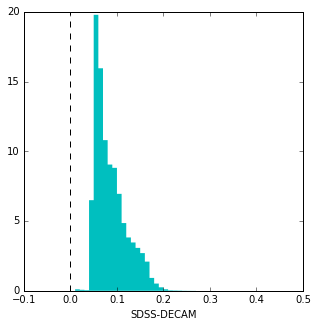

In [119]:
figure(figsize=(5,5))
bins = np.arange(-1.0,1,0.01)
hist(sdss_r-decam_r,edgecolor='None',color='c',histtype='stepfilled',bins=bins,normed=True)
pl.xlim(-0.1,0.5)
pl.axvline(0,c='k',ls='--')
pl.xlabel('SDSS-DECAM')

offset = sdss_r-decam_r
print('Median offset: SDSSr-DECAMr = %f mag'%(np.median(offset)));

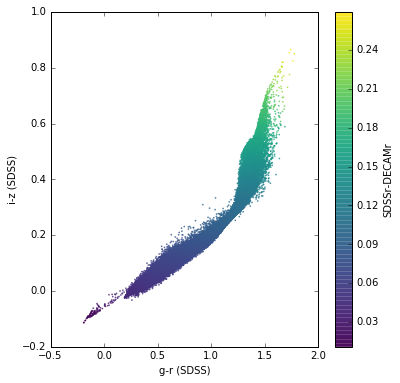

In [126]:
pl.figure(figsize=(6,6))
pl.scatter(sdss_g-sdss_r,sdss_i-sdss_z,c=(sdss_r-decam_r),edgecolor='None',s=3,alpha=0.8,cmap='viridis');
pl.colorbar(label='SDSSr-DECAMr')
pl.xlabel('g-r (SDSS)')
pl.ylabel('i-z (SDSS)');

So SDSSr = DECAMr + 0.08; SDSSr mags are systematically fainter than DECAMr mags.

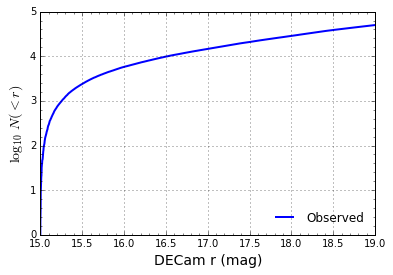

In [125]:
# Everything works fine if we remember our limit is now in DECam mags.
d = decam_r
a = np.argsort(d)
y = np.arange(1,1+len(d))
plot(d[a],np.log10(y),lw=2,c='b',label='Observed')

pl.xlabel('DECam r (mag)',fontsize=14)
pl.ylabel('$\log_{10}\ N(<r)$',fontsize=14)
pl.legend(loc='lower right',frameon=False)
pl.minorticks_on()
pl.grid();

In [124]:
19-0.08

18.92

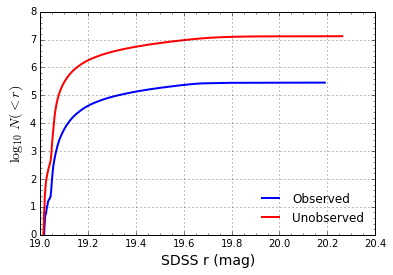

In [131]:
# Observed
d = data_obs['SDSSr_obs'][faint_obs]
a = np.argsort(d)
y = np.arange(1,1+len(d))
plot(d[a],np.log10(y),lw=2,c='b',label='Observed')

# Unobserved
d = data_unobs['SDSSr_obs'][faint_unobs]
a = np.argsort(d)
y = np.arange(1,1+len(d))
plot(d[a],np.log10(y),lw=2,c='r',label='Unobserved')

pl.xlabel('SDSS r (mag)',fontsize=14)
pl.ylabel('$\log_{10}\ N(<r)$',fontsize=14)
pl.legend(loc='lower right',frameon=False)
pl.minorticks_on()
pl.grid();

## 4. Coordinates

In [132]:
# Objects for coordinate conversions, MWS_MAIN only
c_obs   = c.SkyCoord(data_obs[main_obs]['RA'],data_obs[main_obs]['DEC'],unit='deg',frame='icrs')
c_unobs = c.SkyCoord(data_unobs[main_unobs]['RA'],data_unobs[main_unobs]['DEC'],unit='deg',frame='icrs')

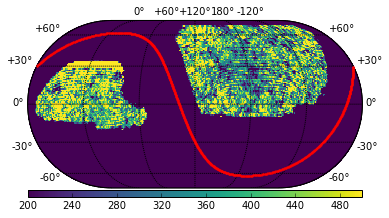

In [133]:
desiplots.plot_sky_binned(c_obs.ra,c_obs.dec,max_bin_area=1,clip_lo=200,clip_hi=500);

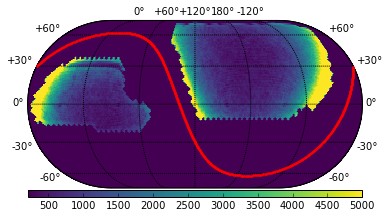

In [134]:
desiplots.plot_sky_binned(c_unobs.ra,c_unobs.dec,max_bin_area=1,clip_lo=200,clip_hi=5000);

The odd patch in the South above dec = +30 is probably the result of using an older BGS mock that doesn't cover that area.

In [135]:
# Healpix binning
import healpy as hp
NSIDE = 2**6 # 64, about 0.8 sq. deg.

def ra_dec_ang2pix(nside,ra,dec,nest=True):
    """
    Converts (ra, dec) in degrees to Healpix pixels, using ang2pix, assuming
    nest and taking into account differences in coordinate conventions.
    """
    theta = np.deg2rad(90.0-dec)
    phi   = np.deg2rad(ra)
    return hp.ang2pix(nside,theta,phi,nest=nest)

def ra_dec_pix2ang(nside,ipix,nest=True):
    """
    Converts Healpix ipix to (ra, dec) in degrees, using pix2ang, assuming
    nest and taking into account differences in coordinate conventions.
    """
    theta, phi = hp.pix2ang(nside,ipix,nest=nest)
    dec = -np.rad2deg(theta) + 90.0
    ra  = np.rad2deg(phi)
    return ra, dec

def pix_counts(nside,ra,dec):
    """Count in each pixel"""
    all_ipix           = ra_dec_ang2pix(nside,ra,dec)
    ipix,ipix_count    = np.unique(all_ipix,return_counts=True)
    allpix_count       = np.zeros(hp.nside2npix(nside),dtype=np.float32)
    allpix_count[ipix] = ipix_count
    return allpix_count
    

## 5. Completeness 

#### Counts of observed and unobserved targets in healpix pixels.

In [136]:
ipix_count_obs   = pix_counts(NSIDE,c_obs.ra.value,c_obs.dec.value)
ipix_count_unobs = pix_counts(NSIDE,c_unobs.ra.value,c_unobs.dec.value)

In [137]:
ipix_count_total = ipix_count_obs + ipix_count_unobs
ipix_count_ratio = ipix_count_obs/ipix_count_total

/gpfs/data/dph3apc/anaconda/3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [138]:
# Pixel coordinates, Galactic
ra_ipix, dec_ipix = ra_dec_pix2ang(NSIDE,np.arange(0,hp.nside2npix(NSIDE)))
c_pix = c.SkyCoord(ra_ipix,dec_ipix,unit='deg',frame='icrs')
l_pix = c_pix.galactic.l
b_pix = c_pix.galactic.b

#### Completeness across sky.

Highlighting (in red) pixels around the edge of the footprint where completeness is artificially low.

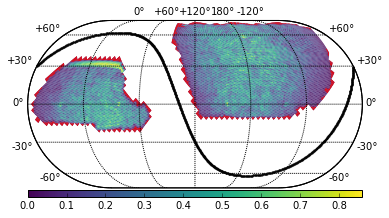

In [139]:
basemap = desiplots.init_sky(galactic_plane_color='k')
desiplots.plot_healpix_map(ipix_count_ratio,nest=True,basemap=basemap)
z = np.where((ipix_count_total > 0) & (ipix_count_ratio == 0))[0]
desiplots.plot_sky_circles(ra_ipix[z],dec_ipix[z],basemap=basemap,field_of_view=1,facecolors='r',edgecolor='None');

#### Fraction of survey area above a given completeness.

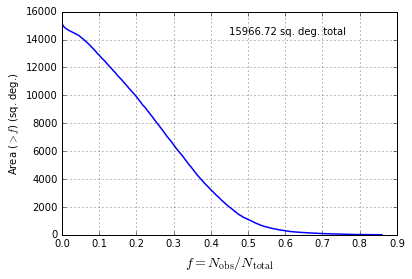

In [140]:
x = ipix_count_ratio[ipix_count_total > 10]
total_area = hp.nside2pixarea(NSIDE,degrees=True)*len(x)

a = np.argsort(x)
y = np.arange(1,len(x)+1)/float(len(x))
pl.plot(x[a[::-1]],y*total_area,lw=1.5)

ax = pl.gca()
pl.text(0.5,0.9,'{:6.2f} sq. deg. total'.format(total_area),transform=ax.transAxes)
pl.grid()
pl.xlabel('$f = N_{\mathrm{obs}}/N_{\mathrm{total}}$',fontsize=14)
pl.ylabel('Area ($>f$) (sq. deg.)');

#### Completeness in Healpix pixels.

Scatter plot of completeness in each pixel vs. the Galactic latitude of that pixel.

Restriction to having > 10 stars available to limit contribution of pixels at the edge of the footprint.

/gpfs/data/dph3apc/anaconda/3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Total area of (partly) observed HP pixels: 15166.036169 sq. deg.


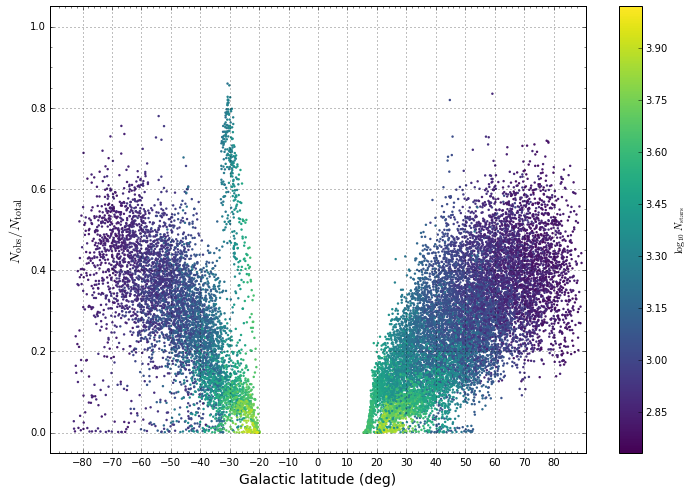

In [ ]:
pl.figure(figsize=(12,8))

s = (ipix_count_total > 10) & (ipix_count_ratio > 0)
print('Total area of (partly) observed HP pixels: {:f} sq. deg.'.format(s.sum()*hp.nside2pixarea(NSIDE,degrees=True)))
pl.scatter(b_pix[s],ipix_count_ratio[s],
           c=np.log10(ipix_count_total[s]),
           cmap='viridis',
           s=6,
           edgecolor='None')
cbar = pl.colorbar(label='$\log_{10}\ N_{\mathrm{stars}}$')
pl.ylim(-0.05,1.05)
pl.xlim(-91,91)
pl.ylabel('$N_{\mathrm{obs}}/N_{\mathrm{total}}$',fontsize=14)
pl.xlabel('Galactic latitude (deg)',fontsize=14)

ax = pl.gca()
pl.xticks(np.arange(-80,90,10))
pl.minorticks_on()
pl.grid()

#### Distant stars

Ratio of observed/available for the subset of distant stars (>30 kpc).

In [ ]:
distant_o =  data_obs['d_helio'][main_obs] > 30.0
distant_u =  data_unobs['d_helio'][main_unobs] > 30.0

ipix_count_d_obs   = pix_counts(NSIDE,c_obs.ra.value[distant_o],c_obs.dec.value[distant_o])
ipix_count_d_unobs = pix_counts(NSIDE,c_unobs.ra.value[distant_u],c_unobs.dec.value[distant_u])
ipix_count_d_total = ipix_count_d_obs + ipix_count_d_unobs
ipix_count_d_ratio = ipix_count_d_obs/ipix_count_d_total

pl.figure(figsize=(12,8))

# Note these refer to the full sample, not the distant subset (no _d)
have_any_stars = ipix_count_total > 10
have_observed  = ipix_count_ratio > 0

s_d = have_any_stars & have_observed
print('Total area of HP pixels with at least 10 targets: {:f} sq. deg.'.format(have_any_stars.sum()*hp.nside2pixarea(NSIDE,degrees=True)))
print('Of which, with at least one observation: {:f} sq. deg.'.format(s.sum()*hp.nside2pixarea(NSIDE,degrees=True)))

pl.scatter(b_pix[s_d],ipix_count_d_ratio[s_d],
           c=ipix_count_d_total[s_d],
           cmap='viridis',
           s=6,
           alpha=0.5,
           edgecolor='None')
cbar = pl.colorbar(label='Total Stars')
pl.ylim(-0.05,1.05)
pl.xlim(-91,91)
pl.ylabel('$N_{\mathrm{obs}}/N_{\mathrm{total}}$',fontsize=14)
pl.xlabel('Galactic latitude (deg)',fontsize=14)

ax = pl.gca()
pl.xticks(np.arange(-80,90,10))
pl.minorticks_on()
pl.grid()

In pixels that have at least one star available **and** at least one star observed:

In [ ]:
print('Total stars available: {:d}'.format(int(np.sum(ipix_count_total[s]))))
print('Total stars observed:  {:d}'.format(int(np.sum(ipix_count_obs[s]))))

print('Ratio: {:f}'.format(np.sum(ipix_count_obs[s])/np.sum(ipix_count_total[s])))

In [ ]:
print('Total distant stars available: {:d}'.format(int(np.sum(ipix_count_d_total[s_d]))))
print('Total distant stars observed:  {:d}'.format(int(np.sum(ipix_count_d_obs[s_d]))))

print('Ratio: {:f}'.format(np.sum(ipix_count_d_obs[s_d])/np.sum(ipix_count_d_total[s_d])))

In [ ]:
print('Median density of distant stars: {:5.1f} per sq.deg.'.format(np.median(ipix_count_d_total[s])/pixarea))
print('Median density of distant stars observed: {:5.1f} per sq.deg.'.format(np.median(ipix_count_d_obs[s])/pixarea))
print('Median completeness of distant stars: {:5.3f}'.format(np.median(ipix_count_d_ratio[s])))
print('Mean completeness of distant stars: {:5.3f}'.format(np.average(ipix_count_d_ratio[s])))
print('St.dev. of completeness of distant stars: {:5.3f}'.format(np.std(ipix_count_d_ratio[s])))

In [ ]:
pl.figure(figsize=(14,8))
bins_all = np.arange(0,13000,100.0)
bins = np.arange(0,100,1.0)

ax = pl.subplot(221)
pl.hist(ipix_count_total[s]/pixarea,bins=bins_all,
        weights=np.ones_like(ipix_count_total[s])*pixarea,
        histtype='stepfilled',color='r');
pl.xlabel('Density')
pl.xlim(0,2000)
pl.ylabel('Area with density')
pl.title('Available targets: all stars')
pl.minorticks_on()
pl.grid()

ax = pl.subplot(222)
pl.hist(ipix_count_obs[s]/pixarea,bins=bins,
        weights=np.ones_like(ipix_count_total[s])*pixarea,
        histtype='stepfilled',color='r');
pl.xlabel('Density')
pl.xlim(0,50)
pl.ylabel('Area with density')
pl.title('Observed targets: all stars')
pl.minorticks_on()
pl.grid()

ax = pl.subplot(223)
pl.hist(ipix_count_d_total[s_d]/pixarea,bins=bins,
        weights=np.ones_like(ipix_count_d_total[s_d])*pixarea,
        histtype='stepfilled',color='c');
pl.xlim(0,50)
pl.xlabel('Density')
pl.ylabel('Area with density')
pl.title('Available targets: distant stars')
pl.minorticks_on()
pl.grid()

ax = pl.subplot(224)
pl.hist(ipix_count_d_obs[s_d]/pixarea,bins=bins,
        weights=np.ones_like(ipix_count_d_total[s_d])*pixarea,
        histtype='stepfilled',color='c');
pl.xlim(0,50)
pl.xlabel('Density')
pl.ylabel('Area with density')
pl.title('Observed targets: distant stars')
pl.minorticks_on()
pl.grid()

pl.subplots_adjust(hspace=0.5)

#### Observed vs. Target density in Healpix pixels

In [ ]:
pl.figure(figsize=(12,8))
pixarea = hp.nside2pixarea(NSIDE,degrees=True)
s = (ipix_count_total > 10) & (ipix_count_ratio > 0)
print('Total area of (partly) observed HP pixels: {:f} sq. deg.'.format(s.sum()*pixarea))
pl.scatter(ipix_count_total[s]/pixarea,ipix_count_obs[s]/pixarea,
           c=np.abs(b_pix[s]),
           cmap='viridis',
           s=6,
           edgecolor='None')
cbar = pl.colorbar(label='Galactic latitude (deg.)')
pl.ylim(-0.05,2500)
pl.ylabel('Targets observed (N/sq.deg.)',fontsize=14)
pl.xlabel('Targets available (N/sq.deg.)',fontsize=14)

ax = pl.gca()
pl.minorticks_on()
pl.grid()